In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (62.4 MB/s)
(Reading database ... 155685 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155663 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

In [ ]:
!pip install -U tensorflow tensorflow_datasets

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models


#Set seed value for reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the `mini Speech Commands dataset`

In [2]:
DATASET_PATH = '/content/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract = True, 
      cache_dir = '.', cache_subdir = 'data'
      )

### The dataset's audio clips are stored in eight directories corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right` and `stop`.

In [3]:
data_dir = '/content/data/mini_speech_commands'

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[commands != 'README.md']
print(f'Commands: {commands}')

Commands: ['left' 'go' 'yes' 'stop' 'up' 'down' 'right' 'no']


#### The audio clips are 1 second or less at 16kHz. The `output_seqence_length = 16_000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can easily be batched.

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir, 
    batch_size = 64, 
    validation_split = 0.2, 
    seed = 0,
    output_sequence_length = 16_000, 
    subset = 'both'
)

label_names = np.array(train_ds.class_names)
print('Label names: ', label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
Label names:  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so the use of `tf.squeeze` function to drop the entire axis.

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis = -1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to 2 splits. It is a good idea to keep a test set separate from your validation set. You can use `Dataset.shard` to split the validation set into 2 halves.

In [8]:
test_ds = val_ds.shard(num_shards = 2, index = 0)
val_ds = val_ds.shard(num_shards = 2, index = 1)


for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Visualize a few audio waveforms.

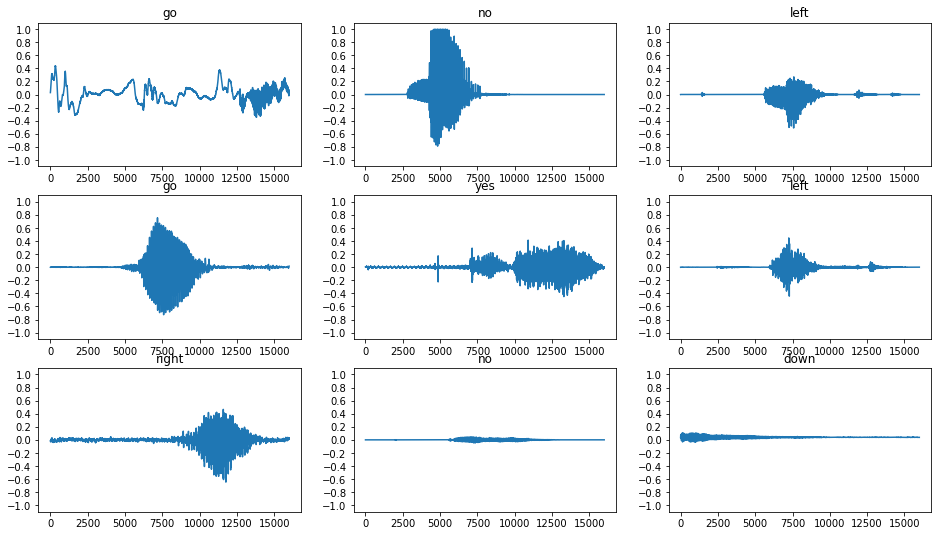

In [9]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize = (16, 9))

for item in range(n):
  if item >= n:
    break
  
  r = item // cols
  c = item % cols
  ax = axes[r][c]
  ax.plot(example_audio[item].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  
  label = label_names[example_labels[item]]
  ax.set_title(label)
  ax.set_ylim([-1.1, 1.1])

plt.show()

## Convert waveforms to spectograms.

This step involves transforming waveforms from the time domain signals into the time-frequency domain signals b computing the `short-time Fourier transform` to convert the waveforms to as spectograms which show frequency changes over time and can be represented as 2D images. 
The spectogram images are then fed into a neiral net to train the model.


A Fourier transform `tf.signal.fft` converts a signal to its component frequencies, but loses all time information.

 In comparison, STFT `tf.signal.stft` splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

In [10]:
#Utility function to convert waveforms to spectograms.
def get_spectogram(waveform):
  #Converts the waveform to a spectogram via a STFT.
  spectogram = tf.signal.stft(
      waveform, frame_length = 255, frame_step = 128)
  
  #Obtain the magnitude of STFT.
  spectogram = tf.abs(spectogram)

  #Add a 'channels' dimension so that the spectogram can be used as image-like input data.
  spectogram = spectogram[..., tf.newaxis]
  return spectogram

In [11]:
#Print the shapes of one example's tensorized waveform and the coresponding spectogram.
for item in range(3):
  label = label_names[example_labels[item]]
  waveform = example_audio[item]
  spectogram = get_spectogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectogram shape: ', spectogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate = 16_000))

Label: go
Waveform shape: (16000,)
Spectogram shape:  (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectogram shape:  (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectogram shape:  (124, 129, 1)
Audio playback


In [12]:
#Define a function for displaying a spectogram.
def plot_spectogram(spectogram, ax):
  if len(spectogram.shape) > 2:
    assert len(spectogram.shape) == 3
    spectogram = np.squeeze(spectogram, axis = - 1)

    #Convert the frequencies to log scale and transpose so that the time is represented on the x axis.
    log_spec = np.log(spectogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]

    X = np.linspace(0, np.size(spectogram), num = width, dtype = int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

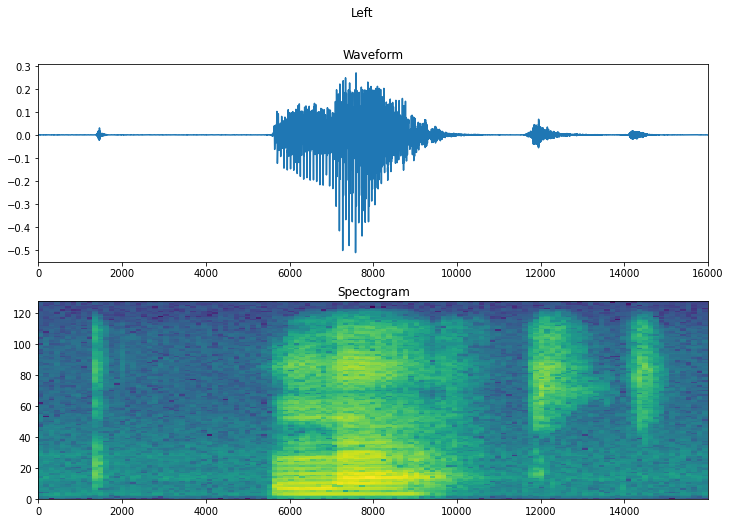

In [13]:
#Plot the example's waveform over time and the corresponding spectogram.
fig, axes = plt.subplots(2, figsize = (12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16_000])

plot_spectogram(spectogram.numpy(), axes[1])
axes[1].set_title('Spectogram')
plt.suptitle(label.title())
plt.show()

In [14]:
#Create spectogram datasets from the audio datasets.
def make_spec_ds(ds):
  return ds.map(
      map_func = lambda audio, label: (get_spectogram(audio), label),
      num_parallel_calls = tf.data.AUTOTUNE
  )

In [15]:
train_spectogram_ds = make_spec_ds(train_ds)
val_spectogram_ds = make_spec_ds(val_ds)
test_spectogram_ds = make_spec_ds(test_ds)

In [16]:
for example_spectrograms, example_spect_labels in train_spectogram_ds.take(1):
  break

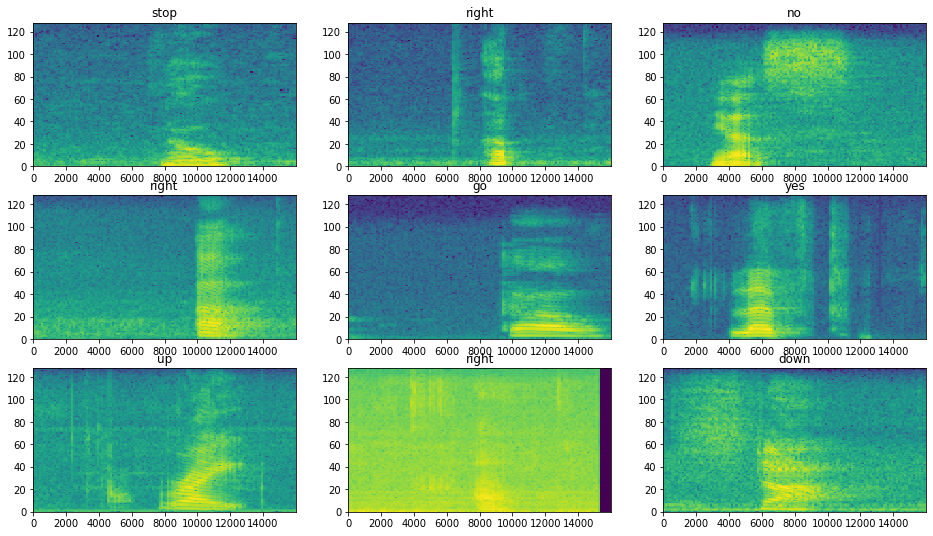

In [17]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize = (16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## Build and train model.
Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model.

In [18]:
train_spectrogram_ds = train_spectogram_ds.cache().shuffle(10_000).prefetch(tf.data.AUTOTUNE)
val_spectrograms_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrograms_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Your model will use the following preprocessing layers: 
- `tf.keras.layers.Resizing` to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization` to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` memthod would first need to be called on the training data in order to compute aggergate statistics.

In [43]:
input_shape = example_spectrograms.shape[1:]
print('Input shape: ', input_shape)
num_labels = len(commands)

#Instantiate the tf.keras.layers.Normalization layer.
norm_layer = layers.Normalization()

#Fit the state oft the layer to the spectograms with `Normalization.adapt`
norm_layer.adapt(data = train_spectrogram_ds.map(map_func = lambda spec, label: spec))

inputs = layers.Input(shape = input_shape)

#Downsample the input.
x = layers.Resizing(32, 32)(inputs)

#Normalize.
x = norm_layer(x)
x = layers.Conv2D(32, 3, activation = 'relu')(x)
x = layers.Conv2D(64, 3, activation = 'relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_labels)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Input shape:  (124, 129, 1)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_5 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                           

In [44]:
#Compile model with Adam optimizer and cross-entropy loss.
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = 'accuracy'
)

#Train the model over 10 epochs.
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds, 
    validation_data = val_spectrograms_ds, 
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/50
100/100 [==============================] - 2s 9ms/step - loss: 1.8240 - accuracy: 0.3417 - val_loss: 1.6061 - val_accuracy: 0.4753
Epoch 2/50
100/100 [==============================] - 1s 7ms/step - loss: 1.4616 - accuracy: 0.5038 - val_loss: 1.3523 - val_accuracy: 0.5898
Epoch 3/50
100/100 [==============================] - 1s 7ms/step - loss: 1.2487 - accuracy: 0.5755 - val_loss: 1.1928 - val_accuracy: 0.6198
Epoch 4/50
100/100 [==============================] - 1s 7ms/step - loss: 1.0965 - accuracy: 0.6327 - val_loss: 1.0667 - val_accuracy: 0.6445
Epoch 5/50
100/100 [==============================] - 1s 7ms/step - loss: 0.9748 - accuracy: 0.6631 - val_loss: 0.9778 - val_accuracy: 0.6875
Epoch 6/50
100/100 [==============================] - 1s 7ms/step - loss: 0.8797 - accuracy: 0.6959 - val_loss: 0.9117 - val_accuracy: 0.7174
Epoch 7/50
100/100 [==============================] - 1s 7ms/step - loss: 0.8001 - accuracy: 0.7255 - val_loss: 0.8603 - val_accuracy: 0.7201
Epoch 

Text(0, 0.5, 'Accuracy [%]')

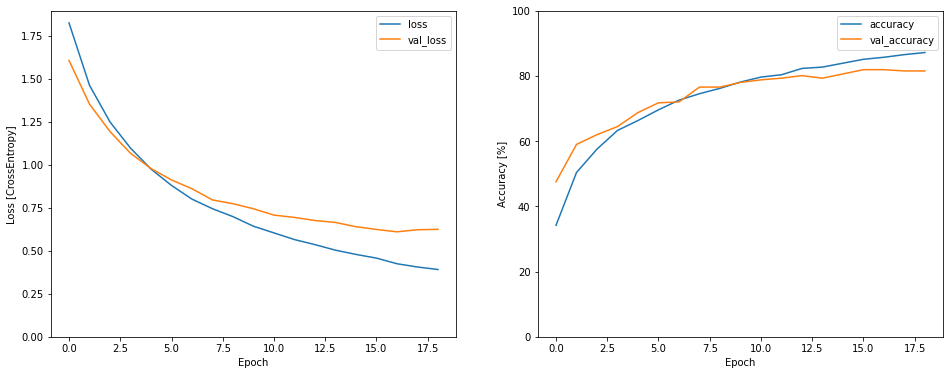

In [45]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Evaluate model performance.

In [46]:
model.evaluate(test_spectrograms_ds, return_dict = True)

13/13 [==============================] - 0s 6ms/step - loss: 0.6374 - accuracy: 0.7969


{'loss': 0.637441873550415, 'accuracy': 0.796875}

#### Display a confusion matrix.

In [47]:
y_pred = model.predict(test_spectrograms_ds)
y_pred = tf.argmax(y_pred, axis = 1)

y_true = tf.concat(list(test_spectrograms_ds.map(lambda s, lab: lab)), axis = 0)

13/13 [==============================] - 0s 3ms/step


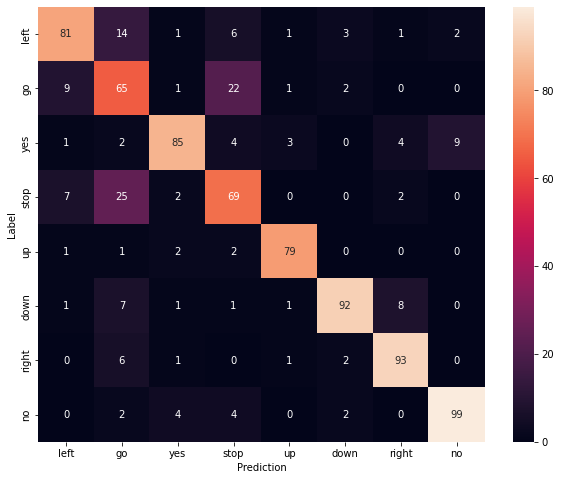

In [48]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (10, 8))
sns.heatmap(confusion_mtx, 
            xticklabels = commands,
            yticklabels = commands, 
            annot = True, fmt = 'g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Perform inference on an audio file.

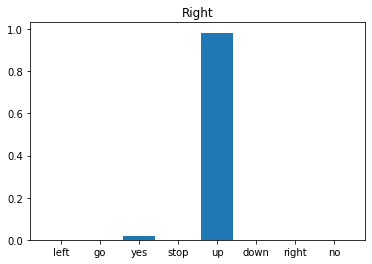

In [49]:
x = '/content/data/mini_speech_commands/right/01d22d03_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels = 1, desired_samples = 16_000, )
x = tf.squeeze(x, axis = -1)
waveform = x
x = get_spectogram(x)
x = x[tf.newaxis, ...]

prediction = model(x)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('Right')
plt.show()

display.display(display.Audio(waveform, rate = 16_000))